In [6]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt 


from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder

from scipy import stats
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import accuracy_score,  precision_score, f1_score, recall_score,classification_report

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


import warnings
warnings.filterwarnings("ignore")

# Pré-processamento dos dados






Lendo a base de dados e dispensando as colunas desnecessárias.

In [3]:
data = pd.read_csv('student_data.csv',sep=',', usecols = lambda column:column not in ['cod_curso','codigo_da_matricula','codigo_do_ciclo_matricula'])
data.head()

,nome_do_curso,carga_horaria_do_curso,eixo_tecnologico,fator_de_esforco_de_curso,tipo_de_curso,turno,codigo_sistec,categoria_de_situacao,data_de_inicio_do_ciclo,data_de_fim_previsto_do_ciclo,vagas_ofertadas,mes_de_ocorrencia_da_situacao,renda,sexo,faixa_etaria,idade,cor,unidade_de_ensino
0,engenharia mecanica,4147,controle e processos industriais,1.07,bacharelado,integral,2809,E,26/08/2019,26/08/2024,41.0,01/01/2021,"0,5<RFP<=1,0",F,20-24,24,parda,Campus João Pessoa
1,engenharia mecanica,4147,controle e processos industriais,1.07,bacharelado,integral,2809,E,26/08/2019,26/08/2024,41.0,01/01/2021,"0,5<RFP<=1,0",M,20-24,23,branca,Campus João Pessoa
2,engenharia mecanica,4147,controle e processos industriais,1.07,bacharelado,integral,2809,E,26/08/2019,26/08/2024,41.0,01/01/2021,"RFP>3,5",M,20-24,21,parda,Campus João Pessoa
3,engenharia mecanica,4147,controle e processos industriais,1.07,bacharelado,integral,2809,E,26/08/2019,26/08/2024,41.0,01/01/2021,"0<RFP<=0,5",M,15-19,19,branca,Campus João Pessoa
4,engenharia mecanica,4147,controle e processos industriais,1.07,bacharelado,integral,2809,E,26/08/2019,26/08/2024,41.0,01/01/2021,"0<RFP<=0,5",M,15-19,19,branca,Campus João Pessoa


Separando os dados. 


*   X = features de cada aluno na base
*   y = variável preditora (coluna **categoria_de_situacao**)



In [4]:
X = data.loc[:,['nome_do_curso',
 'carga_horaria_do_curso',
 'eixo_tecnologico',
 'fator_de_esforco_de_curso',
 'tipo_de_curso',
 'turno',
 'data_de_inicio_do_ciclo',
 'data_de_fim_previsto_do_ciclo',
 'renda',
 'sexo',
 'idade',
 'unidade_de_ensino',
 'mes_de_ocorrencia_da_situacao',
 'faixa_etaria',
 'cor']]
X.head(3)

,nome_do_curso,carga_horaria_do_curso,eixo_tecnologico,fator_de_esforco_de_curso,tipo_de_curso,turno,data_de_inicio_do_ciclo,data_de_fim_previsto_do_ciclo,renda,sexo,idade,unidade_de_ensino,mes_de_ocorrencia_da_situacao,faixa_etaria,cor
0,engenharia mecanica,4147,controle e processos industriais,1.07,bacharelado,integral,26/08/2019,26/08/2024,"0,5<RFP<=1,0",F,24,Campus João Pessoa,01/01/2021,20-24,parda
1,engenharia mecanica,4147,controle e processos industriais,1.07,bacharelado,integral,26/08/2019,26/08/2024,"0,5<RFP<=1,0",M,23,Campus João Pessoa,01/01/2021,20-24,branca
2,engenharia mecanica,4147,controle e processos industriais,1.07,bacharelado,integral,26/08/2019,26/08/2024,"RFP>3,5",M,21,Campus João Pessoa,01/01/2021,20-24,parda


In [5]:
y = data.loc[:,['categoria_de_situacao']]
y.head(3)

,categoria_de_situacao
0,E
1,E
2,E


 <h2>
    Variáveis dummy/fictícias.
  </h2>
Para trabalhar com os algortimos as variáveis categóricas serão transformadas em valores 0 ou 1. O número de variáveis fictícias criadas é de k-1, onde k são os valores possíveis que uma variável categórica pode assumir.

Tendo na coluna **tipo_curso** os valores de:


*   bacharelado
*   tecnologia
*   licenciatura

então tem-se k = 3. E então duas variáveis fictícias são criadas para a coluna tipo_curso. Isso serve para evitar o problema de multicolinearidade que faz com que nossas variáveis fiquem altamente correlacionadas.

Para realizar esse processo usaremos o método OneHotEncoder do sklearn com o parâmetro `drop = first` para criar k-1 variáveis em cada coluna especificada.


In [7]:
enc = OneHotEncoder(handle_unknown='ignore',drop='first') # encoder

In [8]:
# guardando as varáveis categóricas
X_cat = X[['nome_do_curso','eixo_tecnologico',
           'tipo_de_curso','turno','data_de_inicio_do_ciclo','data_de_fim_previsto_do_ciclo','renda','sexo','faixa_etaria','cor',
           'unidade_de_ensino','mes_de_ocorrencia_da_situacao']]
X_cat.head(3)

,nome_do_curso,eixo_tecnologico,tipo_de_curso,turno,data_de_inicio_do_ciclo,data_de_fim_previsto_do_ciclo,renda,sexo,faixa_etaria,cor,unidade_de_ensino,mes_de_ocorrencia_da_situacao
0,engenharia mecanica,controle e processos industriais,bacharelado,integral,26/08/2019,26/08/2024,"0,5<RFP<=1,0",F,20-24,parda,Campus João Pessoa,01/01/2021
1,engenharia mecanica,controle e processos industriais,bacharelado,integral,26/08/2019,26/08/2024,"0,5<RFP<=1,0",M,20-24,branca,Campus João Pessoa,01/01/2021
2,engenharia mecanica,controle e processos industriais,bacharelado,integral,26/08/2019,26/08/2024,"RFP>3,5",M,20-24,parda,Campus João Pessoa,01/01/2021


In [9]:
X_encoded = enc.fit_transform(X_cat).toarray() # codificando as variáveis categóricas

In [10]:
enc.categories_[:2]

[array(['administracao', 'agroecologia', 'alimentos',
        'analise e desenvolvimento de sistemas', 'automacao industrial',
        'ciencias biologicas', 'construcao de edificios',
        'design de interiores', 'design grafico', 'educacao fisica',
        'engenharia civil', 'engenharia de computacao',
        'engenharia de controle e automacao', 'engenharia eletronica',
        'engenharia mecanica', 'fisica', 'geoprocessamento',
        'gestao ambiental', 'gestao comercial', 'informatica',
        'letras - lingua portuguesa', 'matematica', 'medicina veterinaria',
        'negocios imobiliarios', 'quimica', 'redes de computadores',
        'seguranca no trabalho', 'sistemas de telecomunicacoes',
        'sistemas para internet', 'telematica'], dtype=object),
 array(['ambiente e saude', 'controle e processos industriais',
        'desenvolvimento educacional e social', 'gestao e negocios',
        'informacao e comunicacao', 'infraestrutura',
        'producao alimenticia', 'p

In [11]:
X_encoded = pd.DataFrame(X_encoded) # transformando em DataFrame
X_encoded.columns = enc.get_feature_names_out() # renomeando as colunas

In [12]:
X_encoded.head(3)

,nome_do_curso_agroecologia,nome_do_curso_alimentos,nome_do_curso_analise e desenvolvimento de sistemas,nome_do_curso_automacao industrial,nome_do_curso_ciencias biologicas,nome_do_curso_construcao de edificios,nome_do_curso_design de interiores,nome_do_curso_design grafico,nome_do_curso_educacao fisica,nome_do_curso_engenharia civil,...,mes_de_ocorrencia_da_situacao_27/02/2020,mes_de_ocorrencia_da_situacao_27/10/2021,mes_de_ocorrencia_da_situacao_27/12/2018,mes_de_ocorrencia_da_situacao_28/10/2021,mes_de_ocorrencia_da_situacao_29/07/2021,mes_de_ocorrencia_da_situacao_30/01/2018,mes_de_ocorrencia_da_situacao_30/08/2021,mes_de_ocorrencia_da_situacao_30/10/2021,mes_de_ocorrencia_da_situacao_30/11/2021,mes_de_ocorrencia_da_situacao_30/12/2018
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
X_numerical = data[['carga_horaria_do_curso','fator_de_esforco_de_curso','idade']] # guardando as variáveis numéricas
X_numerical.head(3)

,carga_horaria_do_curso,fator_de_esforco_de_curso,idade
0,4147,1.07,24
1,4147,1.07,23
2,4147,1.07,21


In [14]:
X_all = pd.concat([X_encoded, X_numerical],axis=1) # concatenando os dataframes
X_all.head()

,nome_do_curso_agroecologia,nome_do_curso_alimentos,nome_do_curso_analise e desenvolvimento de sistemas,nome_do_curso_automacao industrial,nome_do_curso_ciencias biologicas,nome_do_curso_construcao de edificios,nome_do_curso_design de interiores,nome_do_curso_design grafico,nome_do_curso_educacao fisica,nome_do_curso_engenharia civil,...,mes_de_ocorrencia_da_situacao_28/10/2021,mes_de_ocorrencia_da_situacao_29/07/2021,mes_de_ocorrencia_da_situacao_30/01/2018,mes_de_ocorrencia_da_situacao_30/08/2021,mes_de_ocorrencia_da_situacao_30/10/2021,mes_de_ocorrencia_da_situacao_30/11/2021,mes_de_ocorrencia_da_situacao_30/12/2018,carga_horaria_do_curso,fator_de_esforco_de_curso,idade
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4147,1.07,24
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4147,1.07,23
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4147,1.07,21
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4147,1.07,19
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4147,1.07,19


<h1>Lidando com as diferenças nos valores</h1>

Se observamos os valores a maioria deles está como 0 ou 1. Porém existem duas colunas numéricas na base que são **carga_horaria_do_curso** e **fator_de_esforco_de_curso** que diferem muito disso.

In [15]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler((0,1)) # scaler
X_scaled = sc.fit_transform(X_all) # escolando as variáveis numéricas

In [16]:
# como vira um array, estou convertendo de volta para DataFrame para poder usar o describe
df_scaled = pd.DataFrame(X_scaled)

# agora todos os dados estão dentro do mesmo intervalo 0 e 1
df_scaled.describe()

,0,1,2,3,4,5,6,7,8,9,...,714,715,716,717,718,719,720,721,722,723
count,6586.000000,6586.000000,6586.000000,6586.000000,6586.000000,6586.000000,6586.000000,6586.000000,6586.000000,6586.000000,...,6586.000000,6586.000000,6586.000000,6586.000000,6586.000000,6586.000000,6586.000000,6586.000000,6586.000000,6586.000000
mean,0.044488,0.009110,0.041755,0.045855,0.010325,0.069997,0.028394,0.023231,0.008351,0.034771,...,0.001215,0.000759,0.000607,0.000456,0.000152,0.000456,0.001670,0.424507,0.395097,0.227730
std,0.206193,0.095019,0.200045,0.209186,0.101093,0.255161,0.166107,0.150648,0.091009,0.183212,...,0.034834,0.027545,0.024639,0.021339,0.012322,0.021339,0.040837,0.191199,0.341202,0.157888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.284419,0.000000,0.113208
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.412357,0.357143,0.188679
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.521491,0.714286,0.301887
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<h3>Codificando a variável dependente <b>categoria_de_situacao</b></h3>
Assim como os valores das features categóricas em X foram transformados em 0 e 1 o mesmo será feito com y. Como é apenas uma única coluna usa-se o LabelEncoder.

In [17]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_encoded

array([1, 1, 1, ..., 1, 0, 1])

A varíavel vira um array numpy após esse processo. Podemos converter de volta para DataFrame para observar melhor os valores armazenando em um nova variável. 

In [19]:
df = pd.DataFrame(y_encoded, columns = ['categoria_de_situacao'])

df.head(6)
# concluise que:
# E = 1
# C = 0

,categoria_de_situacao
0,1
1,1
2,1
3,1
4,1
5,1


In [20]:
# observando os tipos das variáveis
print(type(X_scaled))
print(type(y_encoded))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


<h1>Separando os dados em conjunto de treino e teste</h1>
Será utilizado 20% dos dados para teste e 80% para treino.

In [22]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y_encoded,test_size=0.2,random_state=42)

In [24]:
print(f"Para X_train tem-se {X_train.shape[0]} linhas e {X_train.shape[1]} colunas:{X_train.shape}")
print(f"Para X_test tem-se {X_test.shape[0]} linhas e {X_test.shape[1]} colunas:{X_test.shape}")
print(f"Para y_train tem-se {y_train.shape[0]} linhas com os valores de classe referentes a cada amostra em X_train:{y_train.shape}")
print(f"Para y_test tem-se {y_train.shape[0]} linhas com os valores de classe referentes a cada amostra em X_test:{y_test.shape}")

Para X_train tem-se 5268 linhas e 724 colunas:(5268, 724)
Para X_test tem-se 1318 linhas e 724 colunas:(1318, 724)
Para y_train tem-se 5268 linhas com os valores de classe referentes a cada amostra em X_train:(5268,)
Para y_test tem-se 5268 linhas com os valores de classe referentes a cada amostra em X_test:(1318,)


In [29]:
print(X_train)

[[0.         0.         0.         ... 0.24546676 0.10714286 0.37735849]
 [0.         0.         0.         ... 0.5486904  0.         0.33962264]
 [0.         0.         0.         ... 0.5486904  0.         0.11320755]
 ...
 [0.         0.         0.         ... 0.18132975 0.53571429 0.09433962]
 [0.         0.         0.         ... 0.1450638  0.         0.24528302]
 [0.         0.         0.         ... 0.         0.         0.24528302]]


In [30]:
print(X_test)

[[0.         0.         0.         ... 0.79214238 0.35714286 0.18867925]
 [0.         0.         0.         ... 0.49126931 0.         0.35849057]
 [0.         0.         0.         ... 1.         0.75       0.16981132]
 ...
 [0.         0.         0.         ... 1.         0.75       0.13207547]
 [0.         0.         0.         ... 0.28441907 0.82142857 0.16981132]
 [0.         0.         0.         ... 0.32303559 0.39285714 0.09433962]]


In [32]:
print(y_train)
print(y_test)

[1 0 1 ... 0 0 1]
[1 1 1 ... 1 1 1]


# Aplicação dos algoritmos

Definindo os hiperparâmetros para cada modelo

In [34]:
# Logistic Regression
logistic_params = {
    'C': np.linspace(0.1, 10, 20),
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None],
    'random_state': [42],
    'solver': ['liblinear']
}

# Decision Trees
decision_tree_params = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [3, 5, 10, 20],
    'max_features': np.arange(1, X_train.shape[1]),
    'class_weight': ['balanced', None],
    'random_state': [42]
}

# KNN
knn_params= {
    'weights':['uniform','distance'],
    'n_neighbors': np.arange(1,21),
    'metric':['minkowski','euclidean']
}

# SVM
svm_params = {
    'C': np.linspace(0.1, 10, 20),
    'kernel': ['rbf','sigmoid'],
    'class_weight':[None,'balanced'],
    'gamma':['scale',1,0.1,0.01,0.001,0.0001]
}

Definindo os classificadores

In [36]:
classifiers = {
    'LogisticRegression': {
        'model_name': LogisticRegression(),
        'params': logistic_params
    },
    'DecisionTree': {
        'model_name': DecisionTreeClassifier(),
        'params': decision_tree_params
    },
    'KNN': {
        'model_name': KNeighborsClassifier(),
        'params': knn_params
    },
    'SVM': {
        'model_name': SVC(),
        'params': svm_params
    }
}

## Encontrando os melhores hiperparâmetros

Quanto maior for o valor de **AUC**, melhor o nosso modelo está. Através do AUC é possível mensurar o nível de separabilidade do modelo, isto é, o quão bom ele está em prever classes 0 como 0 e classes 1 como 1. Para o nosso caso, quanto maior o AUC, maior a capacidade do modelo em distinguir alunos evadidos (1) de concluintes (0).

Vamos utilizar `RandomizedSearchCV` para encontrar os melhores parâmetros para cada modelo visando o **AUC** como métrica de avaliação primária.

In [39]:
def serch_for_best_params(classifiers, x, y,scoring='roc_auc', cv=9, n_iter=10):

  for model_name, model_attributes in classifiers.items():

        rnd_search = RandomizedSearchCV(model_attributes['model_name'], model_attributes['params'], 
                                                        scoring=scoring, cv=cv,
                                                random_state=42, n_iter=n_iter)
        rnd_search.fit(x, y)

        col_names = [x for x,i in rnd_search.best_params_.items()]

        results = pd.DataFrame(rnd_search.best_params_, columns=col_names, index=[0])
        print(f'Para {model_name}:')
        print(f' Best score:{rnd_search.best_score_}')
        display(results)

In [40]:
serch_for_best_params(classifiers, X_train, y_train)

Para LogisticRegression:
 Best score:0.8657232424098256


,solver,random_state,penalty,class_weight,C
0,liblinear,42,l2,NaN,3.747368


Para DecisionTree:
 Best score:0.7547199903506874


,random_state,max_features,max_depth,criterion,class_weight
0,42,518,20,gini,balanced


Para KNN:
 Best score:0.8330429495313241


,weights,n_neighbors,metric
0,uniform,12,minkowski


Para SVM:
 Best score:0.8426572328526024


,kernel,gamma,class_weight,C
0,rbf,0.01,NaN,8.957895


## Treinando os modelos e avaliando os resultados

In [41]:
# instanciando os modelos com os parâmetros encontrados
knn_clf = KNeighborsClassifier(n_neighbors = 12 , weights = 'uniform', metric='minkowski')
svm_clf = SVC(probability=True, random_state=42, kernel='rbf',gamma=0.01, C=8.957895)
logreg_clf = LogisticRegression(solver='liblinear',penalty='l2',C=3.747368,random_state=42)
tree_clf = DecisionTreeClassifier(max_features=518,max_depth=20,criterion='gini',class_weight='balanced',random_state=42)

In [42]:
# treinando os modelos
knn_clf.fit(X_train, y_train)
svm_clf.fit(X_train, y_train)
logreg_clf.fit(X_train, y_train)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=20, max_features=518,
                       random_state=42)

In [43]:
# função para plotar os resultados
def plot_conf_matrix_and_metrics(y_pred,conf_matrix,model,model_name):
  fig, axs = plt.subplots(1,2, constrained_layout=True,figsize=(9,5))
  
  disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = model.classes_)
  axs[0].set_title(f'Matriz de confusão - {model_name}')
  disp.plot(ax=axs[0],colorbar=False)

  axs[1].axis('off')
  axs[1].set_title(f'Resultados do {model_name}',fontsize=15)
  axs[1].text(0.15,0.8,f'Previu {conf_matrix[1,1]} evadidos corretamente',color='green',va='center',fontsize=10, weight='bold')
  axs[1].text(0.15,0.75,f'Previu {conf_matrix[0,0]} concluintes corretamente',color='green',va='center',fontsize=10, weight='bold')
  axs[1].text(0.15,0.70,f'Previu {conf_matrix[0,1]} como concluintes quando eram evadidos',color='red',va='center',fontsize=10, weight='bold')
  axs[1].text(0.15,0.65,f'Previu {conf_matrix[1,0]} como evadidos quando eram concluintes',color='red',va='center',fontsize=10, weight='bold')

  axs[1].text(0.15,0.50,'Precisão: %.2f' % precision_score(y_test, y_pred),va='center',fontsize=10, weight='bold')
  axs[1].text(0.15,0.45,'Acurácia: %.2f' % accuracy_score(y_test, y_pred),va='center',fontsize=10, weight='bold')
  axs[1].text(0.15,0.40,'F1 Score: %.2f' % f1_score(y_test, y_pred),va='center',fontsize=10, weight='bold')
  axs[1].text(0.15,0.35,'Recall Score: %.2f' % recall_score(y_test, y_pred),va='center',fontsize=10, weight='bold')

  fig.show()


Desempenho do KNN

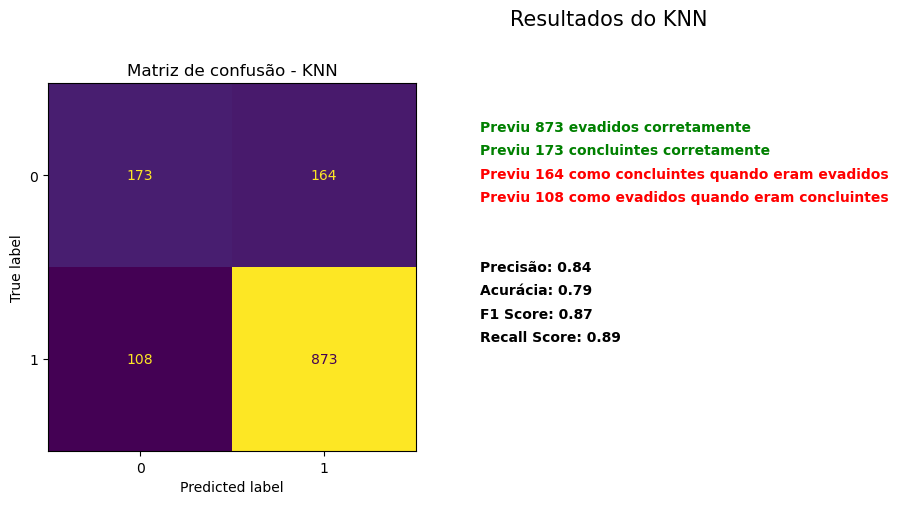

In [45]:
KNNpredicted = knn_clf.predict(X_test)
conf_matrix = confusion_matrix(y_test,KNNpredicted)
plot_conf_matrix_and_metrics(KNNpredicted,conf_matrix,knn_clf,'KNN')

Desempenho do Decision Tree

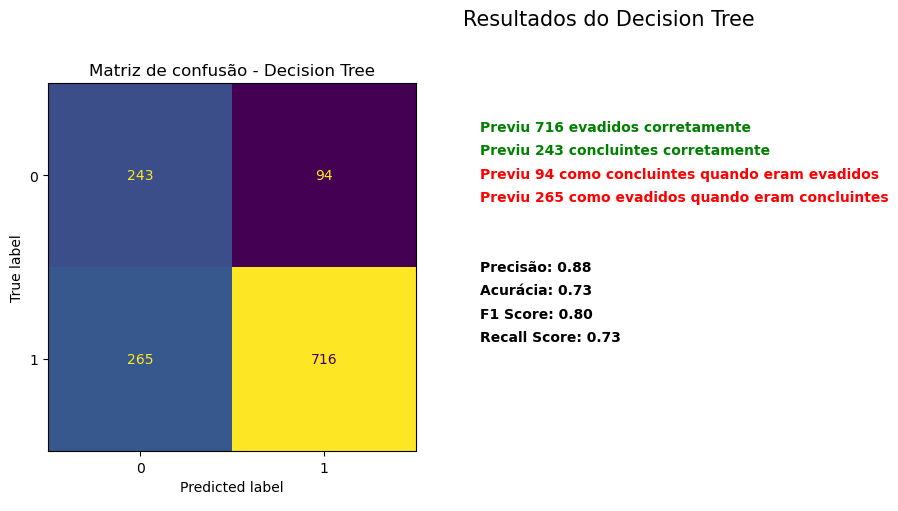

In [49]:
tree_predicted = tree_clf.predict(X_test)
conf_matrix = confusion_matrix(y_test,tree_predicted)
plot_conf_matrix_and_metrics(tree_predicted,conf_matrix,tree_clf,'Decision Tree')

Desempenho do SVM

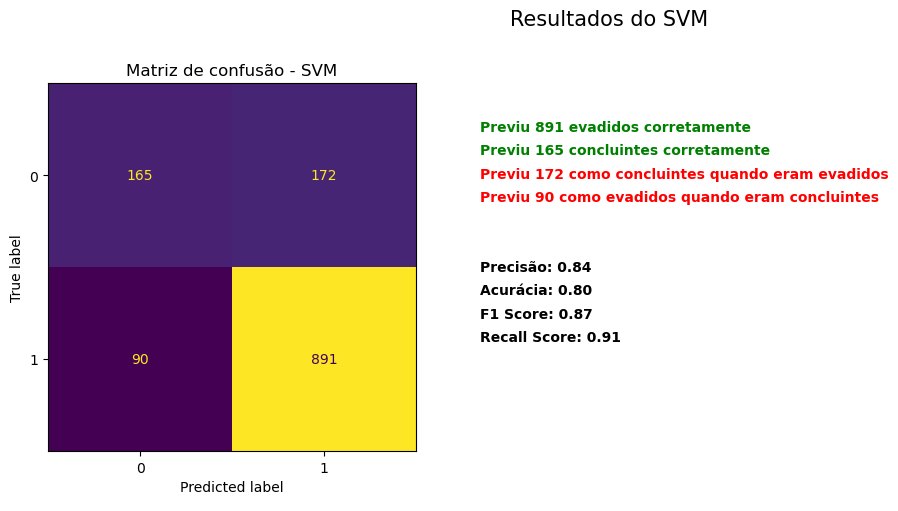

In [50]:
svm_predicted = svm_clf.predict(X_test)
conf_matrix = confusion_matrix(y_test,svm_predicted)
plot_conf_matrix_and_metrics(svm_predicted,conf_matrix,svm_clf,'SVM')

Desempenho do Logistic Regression

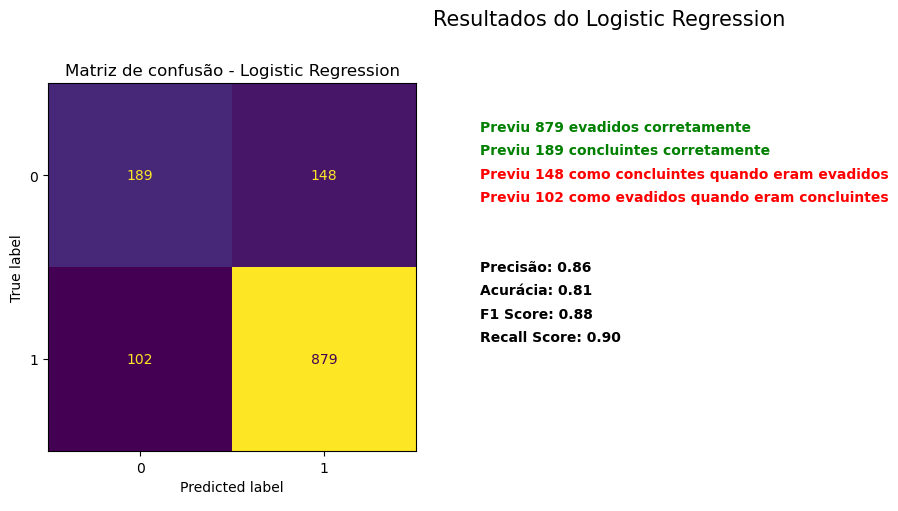

In [51]:
logreg_predicted = logreg_clf.predict(X_test)
conf_matrix = confusion_matrix(y_test,logreg_predicted)
plot_conf_matrix_and_metrics(logreg_predicted,conf_matrix,logreg_clf,'Logistic Regression')

Visualizando a importância das features para o Decision Tree

<AxesSubplot:>

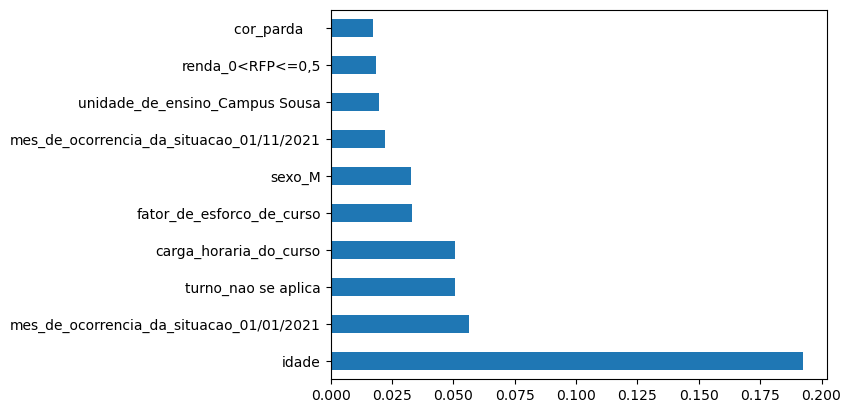

In [78]:
feat_importances = pd.Series(tree_clf.feature_importances_, index=X_all.columns)
feat_importances.nlargest(10).plot(kind='barh')

## Comparando os modelos pela curva ROC

In [70]:
def compare_models_by_roc_curve(model,label_name):
 # fig, ax = plt.subplots()
  # calculando roc
  y_pred_probability = model.predict_proba(X_test)[::,1]
  # calculando também o auc
  fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_probability)
  auc = metrics.roc_auc_score(y_test, y_pred_probability)
  plt.plot(fpr,tpr,label=label_name+",auc="+str(auc))
  plt.legend(loc=4)
  plt.xlabel("False Positive Rate")
  plt.ylabel('True Positive Rate')

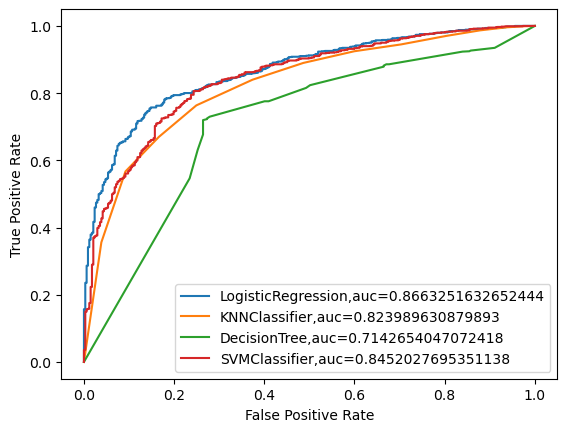

In [71]:
compare_models_by_roc_curve(logreg_clf,"LogisticRegression")
compare_models_by_roc_curve(knn_clf,"KNNClassifier")
compare_models_by_roc_curve(tree_clf,"DecisionTree")
compare_models_by_roc_curve(svm_clf,"SVMClassifier")

Logistic Regression apresentou o melhor AUC, então este será o nosso modelo final.

## Salvando o modelo

In [73]:
import pickle

In [74]:
with open ('logreg_model.pkl','wb') as f:
  pickle.dump([enc, sc, le, logreg_clf], f)